<IPython.core.display.Javascript object>


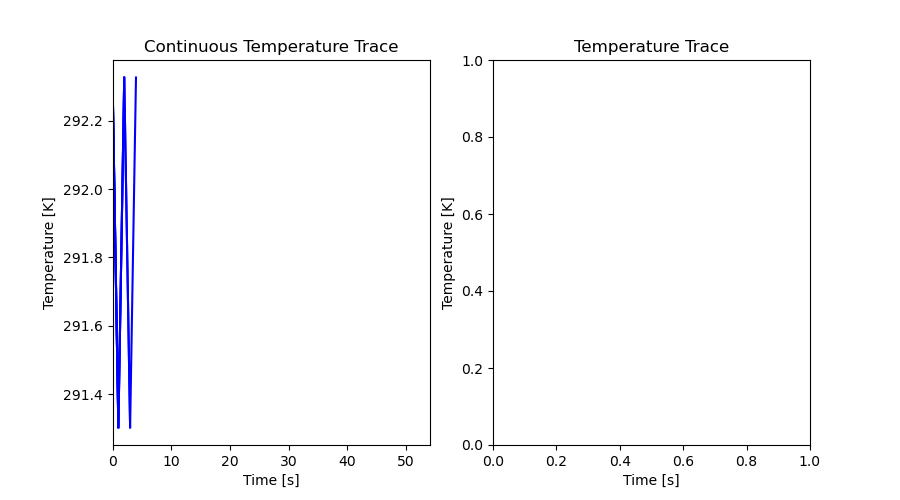

Textarea(value='Oh no! Too many datapoints! Save last temperature trace and restart cell', description='WARNIN…

In [1]:
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Dropdown, Layout, Box, FloatText, Textarea, Label, IntSlider, interact, ToggleButton
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import asyncio
import IPython
import time
import os
import serial

# check the Arduino IDE to see what serial port it's attached to
ser = serial.Serial('COM7', 9600, timeout=1)
# flush any junk left in the serial buffer
ser.flushInput()

def get_data(x):
    alpha = 4.1139e-3; R0 = 1000; R1=1081; Vin=3.272     #should be according to literature: alpha = 3.85e-3 & R0 = 1000
    time.sleep(0.0001)
    ser.reset_input_buffer()
    ser.write(b'g')
#     data = float(str(ser.readline().decode("utf-8"))) 
#     data = float(str(ser.readline().rstrip().decode()))
#     data = float(ser_bytes[0:len(ser_bytes)-2].decode("utf-8"))
#     ser_bytes = ser.readline()
#     data = float(ser_bytes.decode('ascii'))
    Vout = float(ser.readline().decode('ascii'))*(Vin/1023.0)
    Rpt = (Vout*R1)/(Vin-Vout)
    Temp_C = ((Rpt/R0)-1)/alpha
    Temp_K = Temp_C + 273.15
#     ser.close()
    
    return Temp_K

#EXTRA to practice ____________________________________________________________
import psutil

%matplotlib notebook
plt.rcParams['animation.html']='jshtml'

def get_data2(data):
    data = psutil.cpu_percent()
    return data
# till here is what needs to be done to have a live plot in the jupyter notebook itself!
#______________________________________________________________________________

#folder path
path = os.getcwd()

#Values
x_ax, y_ax, y, t_axis, tempTrace_array,T_ave  = [],[],[],[],[],0
Time_opts = [5,10,20,30,60] #dropdown menu for different Temperature trace times
    
### FUNCTIONS ####
class Continuous_trace:
    def __init__(self, checkbox):
        self._checkbox = checkbox

    async def tracing(self):
        global i, x_ax, y_ax 
        i=0
        while True:
            if self._checkbox.value:
                y_ax.append(get_data(1))
                x_ax.append(i)
                ax1.plot(x_ax,y_ax,color='b')
                fig.canvas.draw()
                ax1.set_xlim(left=max(0,i-50),right=i+50)
                time.sleep(0.9)
                i += 1
                if i == 1800:           #for now equal to running this for half an hour (1h = 3600)
                    ser.close()
                    start_button.value = False
                    warninG.layout.visibility = 'visible'
                    break
    
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes

    def start(self):
            asyncio.ensure_future(self.tracing())
        
def countdown(Time):
    global T_ave, tempTrace_array, t_axis,i
    
    tempTrace_array,aver,t_axis,rangeT = [],[],[],Time
    t = Time
    
    start_button.value = False
    while t:
        current_temp = get_data(1)
        curr_time = int(t)
        tempTrace_array.append(current_temp)
        t_axis.append(i)
        mins, secs = divmod(curr_time, 60)
        timeformat = '{:02d}:{:02d}'.format(mins, secs)
        Time_left.value = timeformat
        y_ax.append(current_temp)
        x_ax.append(i)
        ax1.plot(x_ax,y_ax,color='b')
        fig.canvas.draw()
        ax1.set_xlim(left=max(0,i-50),right=i+50)
        t -= 1; i += 1
        time.sleep(1)
    Time_left.value = '00:00'
    T_ave = np.round(np.average(tempTrace_array),3)
    Temp_ave.value = str(T_ave)+' K' 
    for p in range(rangeT):
        aver.append(T_ave)
    
    ax2.clear()
    ax2.set_title('Temperature Trace')
    ax2.set(xlabel='Time [s]', ylabel='Temperature [K]')
    ax2.text(np.average(t_axis), max(tempTrace_array), 'T_ave = '+str(T_ave)+' K', fontsize=10)
    ax2.plot(t_axis,tempTrace_array,color='b')
    ax2.plot(t_axis,aver,'r--')
    fig.canvas.draw()
    
    start_button.value = True
    
def Start_Ttrace_click(_):
    save_plot_button.disabled = True
    countdown(Set_time.value)
    save_plot_button.disabled = False
    
def Save_click(_):
    '''This function will use the names of the students to make a seperate folder where their data is stored
    all they have to do is fill in there name and NOT change it between saves!!!
    appends data of average temperature (of last trace)
    '''
    Folder_name = FileName.value
    stamp = str(datetime.now()).replace(" ","_")
    if Folder_name == '':
        FileName.value = 'Fill in: Student1_Student2!'
    elif Folder_name == 'Fill in: Student1_Student2!':
        FileName.value = 'Fill in: Student1_Student2!!'
    elif Folder_name == 'Fill in: Student1_Student2!!':
        FileName.value = 'Fill in: Student1_Student2!!!'
    elif Folder_name == 'Fill in: Student1_Student2!!!':
        FileName.value = 'GIVE NAME HERE...'
    elif Folder_name == 'GIVE NAME HERE...':
        FileName.value = 'students_on_'+stamp
        print('set to: students_on_ + data of today')
        print('You will find your saved files in the above mentioned directory')
    else:
        Make_save(Folder_name,stamp)
        

def Make_save(Fold_Name,stamp):
    global T_ave
    
    # Create directory
    Year = '_2020_2021';            stempel = stamp[:10];            
    dirName = Fold_Name + Year;     dirName2 = dirName + '/'+stempel
    try:
        # Create target Directory
        os.mkdir(dirName)
    except FileExistsError:
        Folder_val = 'Folder already exist!'
    try:
        # Create sub Directory
        os.mkdir(dirName2)
    except FileExistsError:
        Folder_val = 'Folder already exist!'
        
    #Save figure
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('{}/TempTrace_{}h{}m{}s.pdf'.format(dirName2,stamp[11:13],stamp[14:16],stamp[17:19]), bbox_inches=extent.expanded(1.38, 1.3))
    
    #Save data one appending file
    txtfile = open(dirName2+'/'+Fold_Name+"_average_temps.txt","a+")
    txtfile.write("Temp Trace at {}h{}m{}s with average Temperature {} K\n".format(stamp[11:13],stamp[14:16],stamp[17:19],T_ave))
    txtfile.write("\n")
    txtfile.write("Time [s] \t Temp [K]\n")
    for ko in range(len(tempTrace_array)):
        txtfile.write("%i \t\t %5.2f\n"%(t_axis[ko], tempTrace_array[ko]))
    txtfile.write("\n")
    txtfile.close()
    
    #Save temp trace data
    txtfile = open('{}/TempTrace_{}h{}m{}s.dat'.format(dirName2,stamp[11:13],stamp[14:16],stamp[17:19]),"w")
    txtfile.write("Time [s] \t Temp [K]\n")
    for lo in range(len(tempTrace_array)):
        txtfile.write("%i \t\t %5.2f\n"%(t_axis[lo], tempTrace_array[lo]))
    txtfile.close()
    

### CREATION OF BUTTONS ###
# Buttons
start_button = ToggleButton(description='Start / pause',icon='play')
start_Ttrace_button = Button(description='Start T trace',icon='play') 
save_plot_button = Button(description='Save',icon='save')

# Dropdown / select time
Set_time = widgets.Dropdown(options=Time_opts,    value=5,    description='Trace time[s]:',    disabled=False,)
FileName = widgets.Text(value='',    placeholder='Fill in: Student1_Student2',    description='Name:',    disabled=False)

# Text returning values areas
Temp_ave = widgets.Text(    value='77 K',    placeholder='No average temperature measured', description='T_ave:',    disabled=False)
Time_left = widgets.Text(    value='00:05',    description='Time left:',    disabled=False)

#button clicks
start_Ttrace_button.on_click(Start_Ttrace_click)
save_plot_button.on_click(Save_click)



#### LAYOUT OF BUTTONS AND TEXT AREAS ###
#buttons
top_row = [start_button]
mid_row = [Set_time, start_Ttrace_button,Time_left]
mid_row2 = [Temp_ave]
bottom_row = [FileName,save_plot_button]

box_layout = Layout(display='flex',flex_flow='row',align_items='stretch')

top = Box(children=top_row, layout=box_layout);     mid = Box(children=mid_row, layout=box_layout)
mid2 = Box(children=mid_row2, layout=box_layout);   bottom = Box(children=bottom_row, layout=box_layout)



#### DISPLAY ####
# plot figures
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,5))
ax1.set_title('Continuous Temperature Trace')
ax1.set(xlabel='Time [s]', ylabel='Temperature [K]')
ax2.set_title('Temperature Trace')
ax2.set(xlabel='Time [s]', ylabel='Temperature [K]')

# Buttons
display(VBox([top, mid, mid2, bottom]))
exe = Continuous_trace(start_button)
exe.start()

# Warning for when there's too many data points (equal to halfhour running time)
warninG = widgets.Textarea(value='Oh no! Too many datapoints! Save last temperature trace and restart cell',    
                           description='WARNING!!!', style= {'color': 'red'},
                           width='100%', disabled=True)
display(warninG)
warninG.layout.visibility = 'hidden'

### 12-8-20 at 9:19 am:
* coding works with pyserial plot for arduino!! 
* only now potmeter added to line, with the 5V port of the Arduino Uno
* I do have the feeling that taking the data trace is kinda slow...
* probably need to adjust a few parameters for the time settings
* could also be the ser.close() at the end of the data acquiring function? that makes it so slow
* next up, replace (my own) Uno with the Due!

### 12-8-20 at 9:38 am:
* Arduino Due coupled to the potmeter and connected via COM7
* works the same as before!
* noticed now that the coding breaks down when you take a temperature trace 
* sometimes, for no apparent reason, the entire program shuts down...
    * maybe the serial port can't handle it?
    
### 12-8-20 at 10:03 am:
* maybe it's not the serial port, but a faulty potmeter? too loose in the breadboard?
* this (when it happens at the end of the temperature trace) causes the program to 'shut down'
* the y and x values (list numbers) thus the plot cannot occur -> y isn't appended due to break down of circuit and potmeter

### 12-8-20 10:31 am:
* sometimes access denied to 'COM7', this is due to the issue that the program is interupted and thus doesn't close ser. and it that's not closed the port is in use and when in use your access will be denied!
* reasons for program to interupt arrise around this command: 
        data = float(ser.readline().decode().rstrip())      #data = ser.readline().split(' ')
* either I get the error:
    * could not convert string to float: ''
    * 'utf-8' codec can't decode byte 0xf8 in position 1: invalid start byte
    
...    
    
* somehow, including time.sleep before the command seems to help?
* let's try removing the .rstrip() from the data acquisition...

### 12-8-20 10:57 am:
* .rstrip() removing seems to make it work a bit better
* took out the ser.close() from the function (and not seen anywhere else in code used)
* took ser = ... and ser.flushinput() out of function and placed after imports
* commented ser.reset_input_buffer()
* let's see
    
### 12-8-20 11:10 am:  
* seems to have worked, but still sometimes (very randomly) the continuous temp trace stops working or during temp trace it gives an error: could not convert string to float: ''
* really don't know what to do now...
* other type of error:   ValueError: could not convert string to float: "b'869\\r\\n'

### 12-8-20 12:11 am:  
* I think I fixed it
* had to do start_button.value = True/False at beginning and end of Temp trace!
* seems to work for now, still waiting on next event where something like: could not convert string to float: ''; happens
* next time:
    * replace potmeter with temp sensor and circuit
    * do calculations in get_data(x) function to convert the incoming data into temperatures [K]
    
### 13-8-20 10:36 am:
* adjusted the python and Arduino code
* now the arduino waits for a command from python to read it's analog input port A0
* python sent command to arduino, arduino takes value from A0, sents to python and in python the data will be decoded from a ascii-type string to a float number

### 31-8-20 11:36 am:
* back from 'weggeweest' (crazy bussy with the lFT project)
* hooked up the PT1000 (which is now soldered to 2 wires) to a breadboard within a simple voltage divider setup (other resistor is $1.1 k \Omega$ )
* calculate the voltage comming into the A0 port of the Arduino Due: $\frac{serial_{read} * 3.3V}{1024} = V_{out}$
* from this I calculated the resistance of the PT1000: $Rpt = \frac{V_{out}*R1}{V_{in}-V_{out}}$
* which give a temperature [C]: $Temp_C = \frac{\frac{Rpt}{R0}-1}{\alpha}$
* in Kelvin: $Temp_K = Temp_C + 273.15$, which is sent back from the function to the plotting screen
* for now this seems to work! Later maybe check with liquid nitrogen? See if it then still works?
* check with Gary if we need to increase the voltage range?

# TO DO:
* sometimes there's still this problem with the serial read where it won't respond (except when you close the notebook, shut it down and restart it)
* increase range of temperature sensor? other tricks such as amplification needed?
* combine the sensor with the Mr.SQUID PCB
* combine the codes (redpitaya + arduino)
* check how to save stuff
* create RP questions etc.
* make manual!